# 02 - Exploratory Data Analysis

Explore and validate scraped BaT data before modeling.

**Inputs:**
- `data/raw/bat_listings.parquet`

**Outputs:**
- `data/processed/cleaned_listings.parquet`

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from price_analysis.constants import GT_TRIMS, TRIM_MAPPING, WATER_COOLED_GENS
from price_analysis.data import clean_listings
from price_analysis.data.cleaning import get_summary_stats, prepare_model_data
from price_analysis.visualization.eda_viz import (
    plot_faceted_scatter,
    plot_lowess_curves,
    plot_price_by_category,
    plot_price_heatmap,
    plot_price_scatter,
)

logging.basicConfig(level=logging.INFO)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Paths
DATA_DIR = Path("../data")
RAW_PATH = DATA_DIR / "raw" / "bat_listings.parquet"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH = PROCESSED_DIR / "cleaned_listings.parquet"

## Load Raw Data

In [3]:
df_raw = pd.read_parquet(RAW_PATH)
print(f"Raw data: {len(df_raw)} listings")
display(df_raw.head())

Raw data: 1615 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019.0,991.2,None,Manual,100.0,-to-Sample Meissen Blue,"Novato, California 94949"
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,NaN,None,None,Manual,47000.0,Silver,"Houston, Texas 77098"
2,https://bringatrailer.com/listing/1976-porsche...,1976 Porsche 930 Turbo Carrera Project,102000,2025-12-22,NaN,None,Turbo,Manual,21000.0,Grand Prix White,"Rolling Hills Estate, California 90274"
3,https://bringatrailer.com/listing/1984-porsche...,Modified 1984 Porsche 911 Carrera Coupe,58000,2025-12-23,1984.0,None,Carrera,Manual,111000.0,Reed in Guards Red,"Walnut Creek, California 94597"
4,https://bringatrailer.com/listing/1997-porsche...,34k-Mile 1997 Porsche 911 Carrera Cabriolet 6-...,75000,2025-12-22,1997.0,None,Carrera,Manual,34000.0,Ocean Blue Metallic,"Fort Lauderdale, Florida 33311"


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   listing_url   1615 non-null   object        
 1   title_raw     1615 non-null   object        
 2   sale_price    1615 non-null   int64         
 3   sale_date     1614 non-null   datetime64[ns]
 4   model_year    1564 non-null   float64       
 5   generation    1449 non-null   object        
 6   trim          1478 non-null   object        
 7   transmission  1552 non-null   object        
 8   mileage       1558 non-null   float64       
 9   color         1483 non-null   object        
 10  location      1614 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 138.9+ KB


## Clean and Validate

In [5]:
df = clean_listings(df_raw, drop_invalid=False)
display(df.head())

INFO:price_analysis.data.cleaning:Cleaning 1615 listings
INFO:price_analysis.data.cleaning:Parsed trim: {'Carrera': 319, 'Carrera S': 194, 'Turbo': 186, 'Carrera 4S': 166, 'Turbo S': 109, 'GT3': 101, 'GT3 RS': 76, 'Carrera 4': 67, 'GT3 Touring': 65, 'Carrera GTS': 62, 'Targa 4S': 39, 'Targa': 36, 'Targa 4 GTS': 26, 'GT2 RS': 16, 'Carrera 4 GTS': 12, 'Targa 4': 4}
INFO:price_analysis.data.cleaning:Parsed body_style: {'coupe': 1101, 'cabriolet': 392, 'targa': 105, 'speedster': 17}
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1974-porsche-911-cabiriolet-conversion/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1976-porsche-930-turbo-carrera-31/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/wheels-352/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/transaxle-13/: ['Missing model_year']
ERROR:price

,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,...,mileage_10k,mileage_scaled,log_mileage,log_mileage_scaled,is_low_mileage,color_normalized,color_category,body_style,log_price,is_valid
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019,991.2,None,Manual,100,-to-Sample Meissen Blue,...,0.01,-1.044193,4.615121,-3.005898,1,-to-Sample Meissen Blue,PTS,speedster,13.182517,True
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,<NA>,None,None,Manual,47000,Silver,...,4.7,0.179228,10.757924,0.556076,0,Silver,standard,cabriolet,11.258033,False
2,https://bringatrailer.com/listing/1976-porsche...,1976 Porsche 930 Turbo Carrera Project,102000,2025-12-22,<NA>,None,Turbo,Manual,21000,Grand Prix White,...,2.1,-0.499001,9.952325,0.08894,0,Grand Prix White,standard,coupe,11.532728,False
3,https://bringatrailer.com/listing/1984-porsche...,Modified 1984 Porsche 911 Carrera Coupe,58000,2025-12-23,1984,None,Carrera,Manual,111000,Reed in Guards Red,...,11.1,1.848716,11.617294,1.054391,0,Reed in Guards Red,special,coupe,10.968198,True
4,https://bringatrailer.com/listing/1997-porsche...,34k-Mile 1997 Porsche 911 Carrera Cabriolet 6-...,75000,2025-12-22,1997,None,Carrera,Manual,34000,Ocean Blue Metallic,...,3.4,-0.159886,10.434145,0.368329,0,Ocean Blue Metallic,standard,cabriolet,11.225243,True


### New Features from Parsing

`clean_listings()` now re-parses `title_raw` to extract:
- **GTS trims**: Carrera GTS, Carrera 4 GTS, Targa 4 GTS (previously mislabeled as base Carrera/Targa)
- **Body style**: coupe, cabriolet, targa, speedster (defaulting to coupe for GT cars that omit it)

In [6]:
stats = get_summary_stats(df)
print(f"Total listings: {stats['n_listings']}")
print(f"Valid listings: {stats['n_valid']}")
print(f"Date range: {stats['date_range'][0]} to {stats['date_range'][1]}")
print(f"Price range: ${stats['price_range'][0]:,} to ${stats['price_range'][1]:,}")
print(f"Median price: ${stats['price_median']:,}")
print(f"Median mileage: {stats['mileage_median']:,}")

Total listings: 1615
Valid listings: 1564
Date range: 2024-06-25 00:00:00 to 2025-12-26 00:00:00
Price range: $700 to $1,201,000
Median price: $81,500.0
Median mileage: 30,000.0


## Missing Data Report

In [7]:
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_report = pd.DataFrame({"missing": missing, "pct": missing_pct})
display(missing_report[missing_report["missing"] > 0].sort_values("missing", ascending=False))

,missing,pct
generation,166,10.3
trim,137,8.5
color,132,8.2
color_normalized,132,8.2
transmission,63,3.9
mileage,57,3.5
mileage_10k,57,3.5
mileage_scaled,57,3.5
log_mileage,57,3.5
log_mileage_scaled,57,3.5


## Distribution Plots

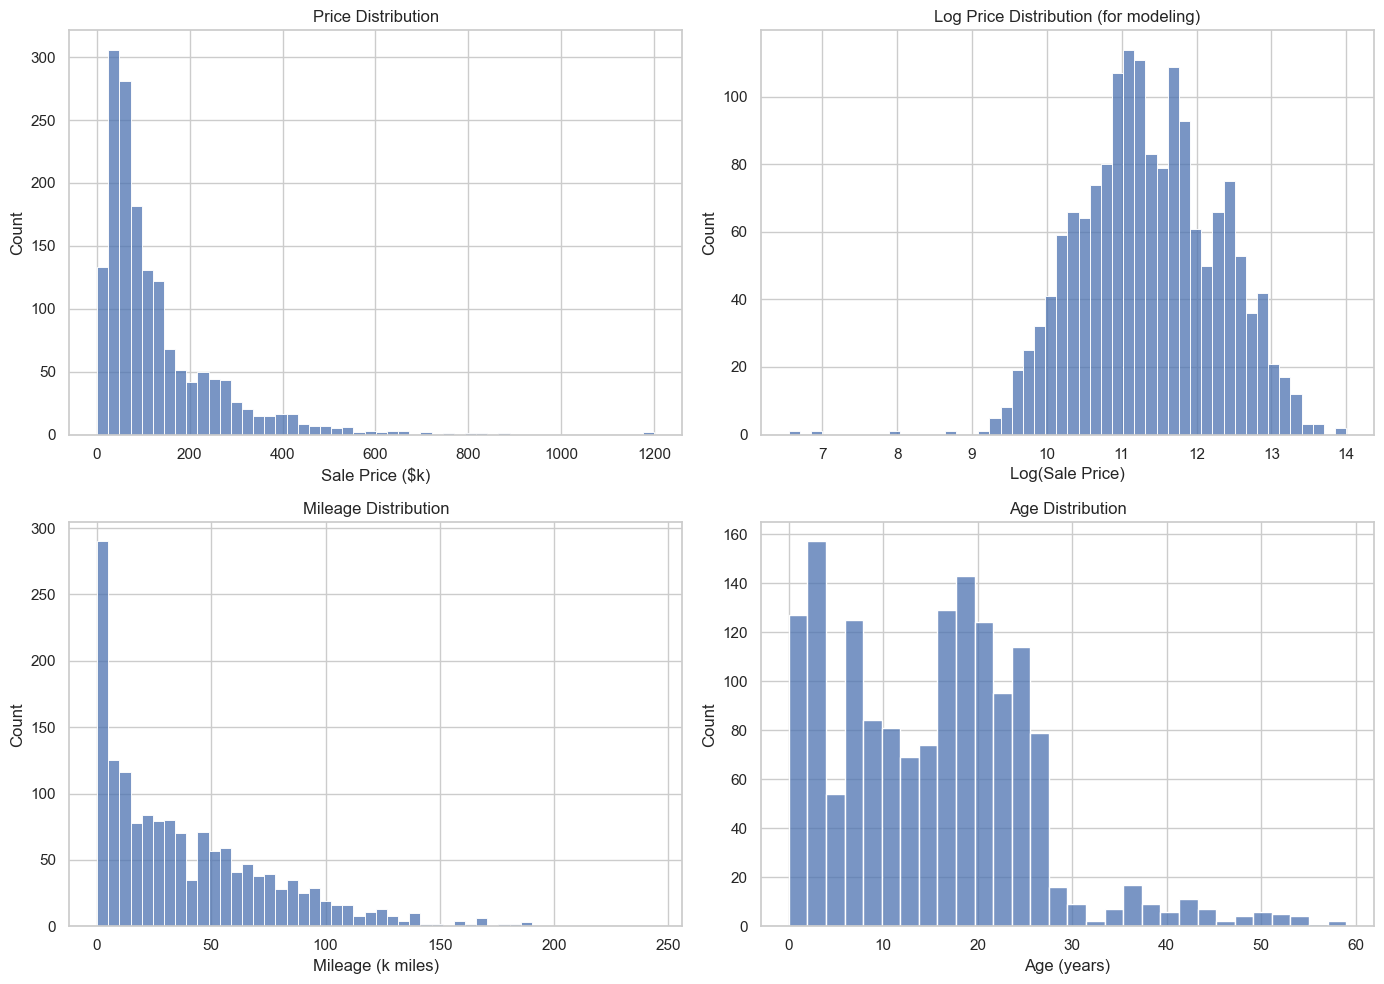

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
sns.histplot(df["sale_price"].dropna() / 1000, bins=50, ax=axes[0, 0])
axes[0, 0].set_xlabel("Sale Price ($k)")
axes[0, 0].set_title("Price Distribution")

# Log price distribution
sns.histplot(df["log_price"].dropna(), bins=50, ax=axes[0, 1])
axes[0, 1].set_xlabel("Log(Sale Price)")
axes[0, 1].set_title("Log Price Distribution (for modeling)")

# Mileage distribution
sns.histplot(df["mileage"].dropna() / 1000, bins=50, ax=axes[1, 0])
axes[1, 0].set_xlabel("Mileage (k miles)")
axes[1, 0].set_title("Mileage Distribution")

# Age distribution
sns.histplot(df["age"].dropna(), bins=30, ax=axes[1, 1])
axes[1, 1].set_xlabel("Age (years)")
axes[1, 1].set_title("Age Distribution")

plt.tight_layout()
plt.show()

## Categorical Counts

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_16883/30889309.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=body_counts.values, y=body_counts.index, ax=axes[1, 1], orient="h", palette="Set2")


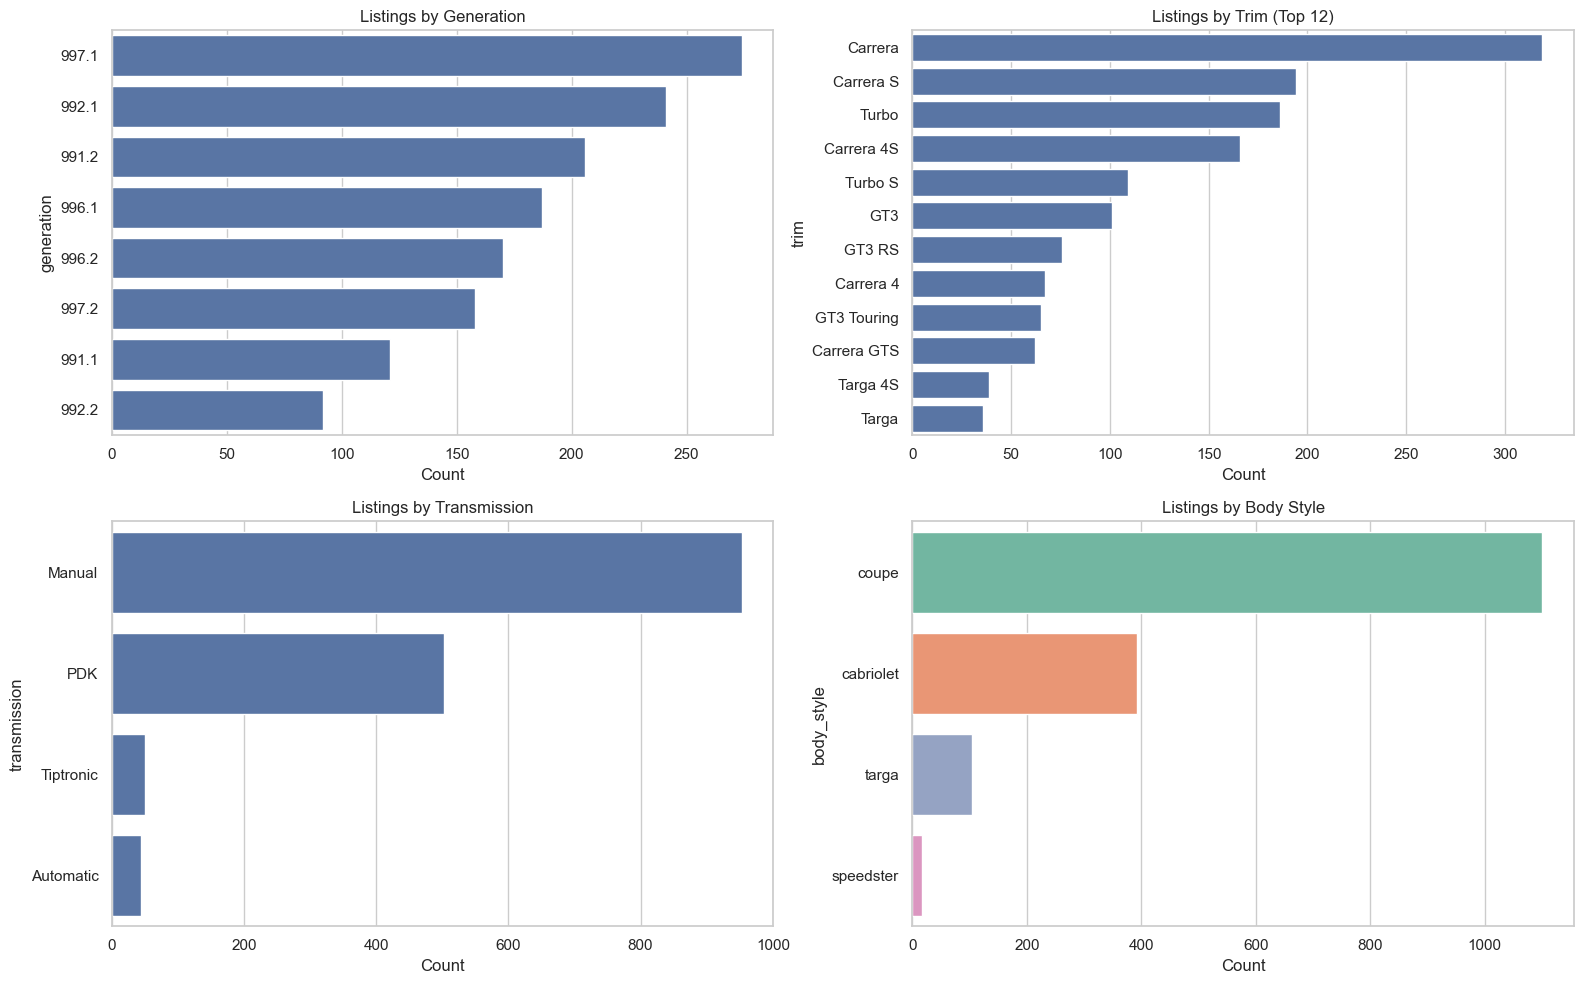

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Generation counts
gen_counts = df["generation"].value_counts()
sns.barplot(x=gen_counts.values, y=gen_counts.index, ax=axes[0, 0], orient="h")
axes[0, 0].set_title("Listings by Generation")
axes[0, 0].set_xlabel("Count")

# Trim counts (top 12 to show GTS variants)
trim_counts = df["trim"].value_counts().head(12)
sns.barplot(x=trim_counts.values, y=trim_counts.index, ax=axes[0, 1], orient="h")
axes[0, 1].set_title("Listings by Trim (Top 12)")
axes[0, 1].set_xlabel("Count")

# Transmission counts
trans_counts = df["transmission"].value_counts()
sns.barplot(x=trans_counts.values, y=trans_counts.index, ax=axes[1, 0], orient="h")
axes[1, 0].set_title("Listings by Transmission")
axes[1, 0].set_xlabel("Count")

# Body style counts
body_counts = df["body_style"].value_counts()
sns.barplot(x=body_counts.values, y=body_counts.index, ax=axes[1, 1], orient="h", palette="Set2")
axes[1, 1].set_title("Listings by Body Style")
axes[1, 1].set_xlabel("Count")

plt.tight_layout()
plt.show()

## Price by Model Year & Sale Date

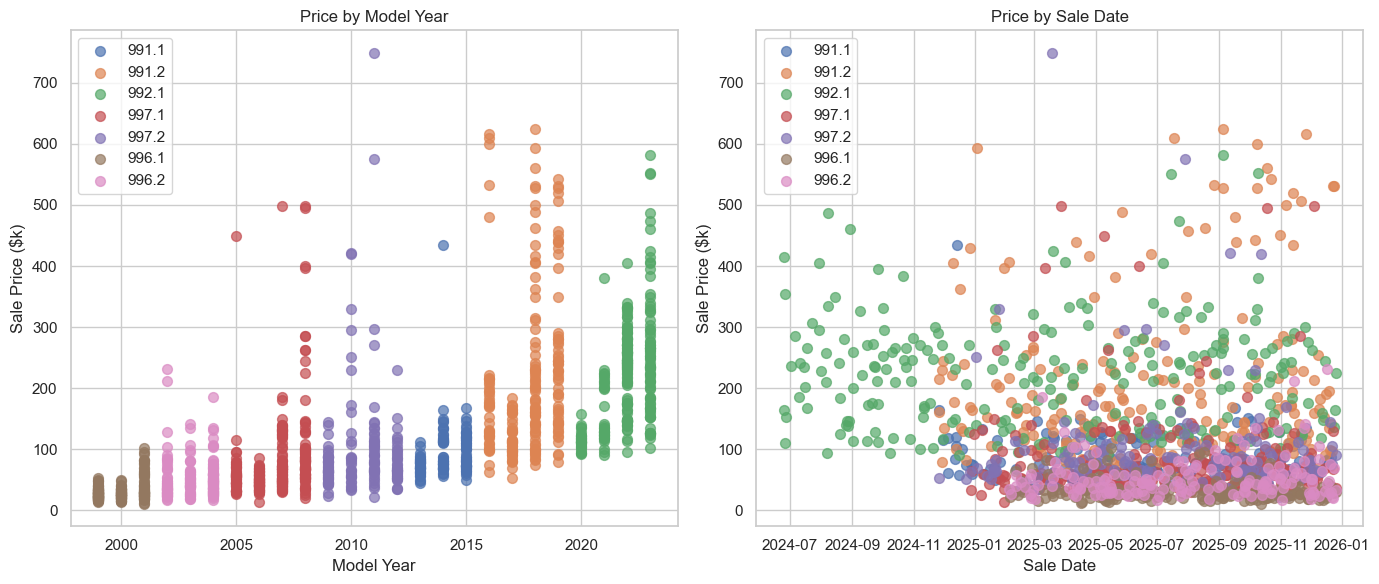

In [10]:
# Focus on key generations
key_gens = ["991.1", "991.2", "992.1", "997.1", "997.2", "996.1", "996.2"]
df_key = df[df["generation"].isin(key_gens)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price by model year (scatter)
ax = axes[0]
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) > 0:
        ax.scatter(
            subset["model_year"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
ax.set_xlabel("Model Year")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price by Model Year")
ax.legend()

# Price over sale time (if enough data)
ax = axes[1]
has_data = False
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) >= 2:  # Need at least 2 points to show trend
        ax.scatter(
            subset["sale_date"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
        has_data = True

if has_data:
    ax.set_xlabel("Sale Date")
    ax.set_ylabel("Sale Price ($k)")
    ax.set_title("Price by Sale Date")
    ax.legend()
else:
    ax.text(
        0.5,
        0.5,
        "Not enough data for time series",
        ha="center",
        va="center",
        transform=ax.transAxes,
    )
    ax.set_title("Price by Sale Date (insufficient data)")

plt.tight_layout()
plt.show()

## Price by Mileage

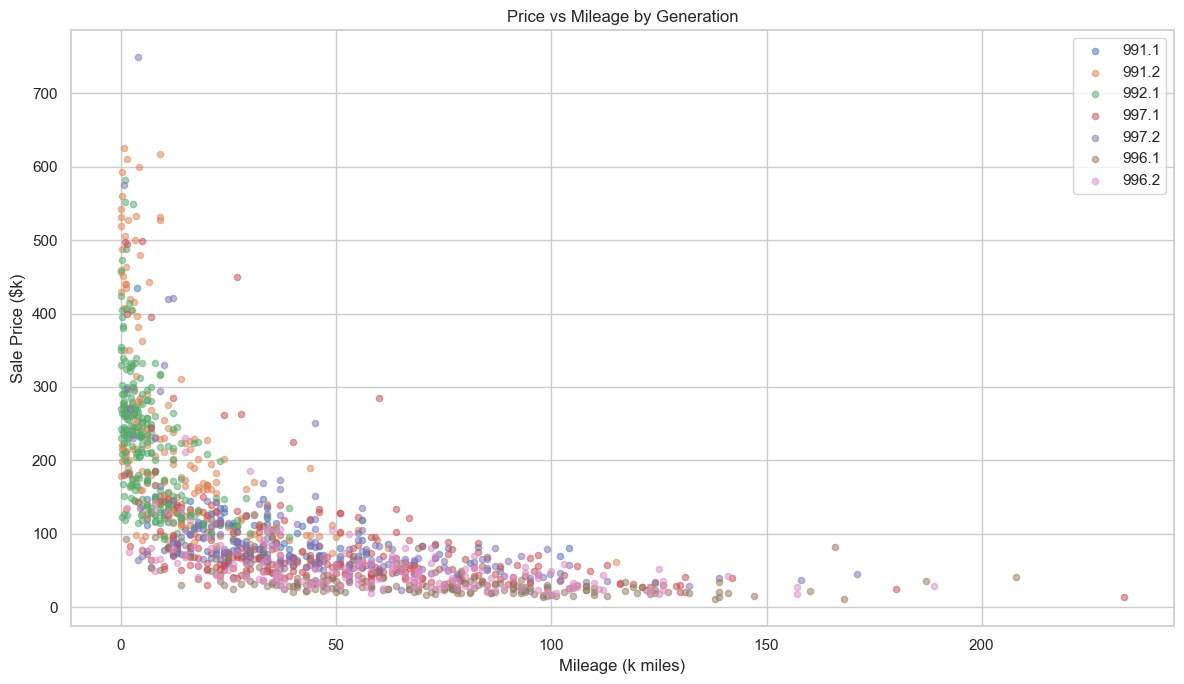

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    ax.scatter(
        subset["mileage"] / 1000,
        subset["sale_price"] / 1000,
        label=gen,
        alpha=0.5,
        s=20,
    )

ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Mileage by Generation")
ax.legend()
plt.tight_layout()
plt.show()

## Manual vs PDK Premium

In [12]:
# Compare manual vs PDK prices
# With small datasets, compare overall (not controlling for generation+trim)
trans_df = df[df["transmission"].isin(["Manual", "PDK"])].copy()

if len(trans_df) > 0:
    # Overall comparison
    print("=== Overall Manual vs PDK ===")
    overall = trans_df.groupby("transmission")["sale_price"].agg(["count", "median", "mean"])
    overall["median"] = overall["median"].apply(lambda x: f"${x:,.0f}")
    overall["mean"] = overall["mean"].apply(lambda x: f"${x:,.0f}")
    display(overall)

    # By generation (if enough data)
    print("\n=== By Generation (where both exist) ===")
    gen_trans = trans_df.groupby(["generation", "transmission"])["sale_price"].agg(
        ["count", "median"]
    )
    gen_trans_wide = gen_trans.unstack("transmission")
    # Only show where we have both Manual and PDK
    gen_trans_wide = gen_trans_wide.dropna()
    if len(gen_trans_wide) > 0:
        display(gen_trans_wide)
    else:
        print("Not enough data - need same generation with both Manual and PDK listings")
else:
    print("No Manual or PDK listings in dataset")

=== Overall Manual vs PDK ===


,count,median,mean
transmission,,,
Manual,953,"$68,500","$116,587"
PDK,503,"$131,000","$175,623"



=== By Generation (where both exist) ===


count           median          
transmission Manual    PDK    Manual       PDK
generation                                    
991.1          17.0  102.0   77000.0   82500.0
991.2          71.0  131.0  210000.0  160000.0
992.1         101.0  137.0  242000.0  199000.0
992.2          33.0   57.0  243000.0  355355.0
997.2          77.0   76.0   83000.0   66000.0

## Correlation Matrix

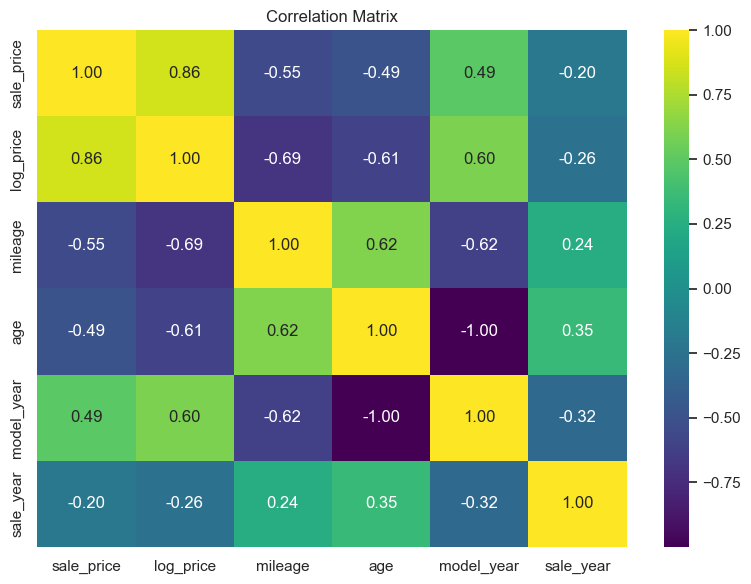

In [13]:
numeric_cols = ["sale_price", "log_price", "mileage", "age", "model_year", "sale_year"]
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", center=0, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Filter & Group Data for Analysis

Focus on water-cooled 911s (996+) with simplified trim groupings:
- **Exclude GTs** (GT3, GT3 RS, GT2 RS, GT3 Touring) - analyzed separately
- **Combine Targas** with corresponding AWD coupes
- **Combine Turbo + Turbo S** into single "Turbo" tier

In [14]:
# Create main analysis dataset (non-GT water-cooled)
df_main = df[
    df["generation"].isin(WATER_COOLED_GENS) & ~df["trim"].isin(GT_TRIMS) & df["trim"].notna()
].copy()

# Apply trim groupings
df_main["trim_grouped"] = df_main["trim"].replace(TRIM_MAPPING)

# Create GT dataset for separate analysis
df_gt = df[df["generation"].isin(WATER_COOLED_GENS) & df["trim"].isin(GT_TRIMS)].copy()

print(f"Main analysis: {len(df_main)} listings (non-GT water-cooled)")
print(f"GT models: {len(df_gt)} listings")
print(f"\nTrim distribution (after grouping):")
display(df_main["trim_grouped"].value_counts().to_frame("count"))

Main analysis: 1128 listings (non-GT water-cooled)
GT models: 251 listings

Trim distribution (after grouping):


,count
trim_grouped,
Carrera,288
Turbo,274
Carrera 4S,200
Carrera S,192
Carrera 4,74
Carrera GTS,62
Carrera 4 GTS,38


## Price Relationships by Key Variables

Visual breakdowns of how price varies with age, mileage, trim, transmission, and generation.

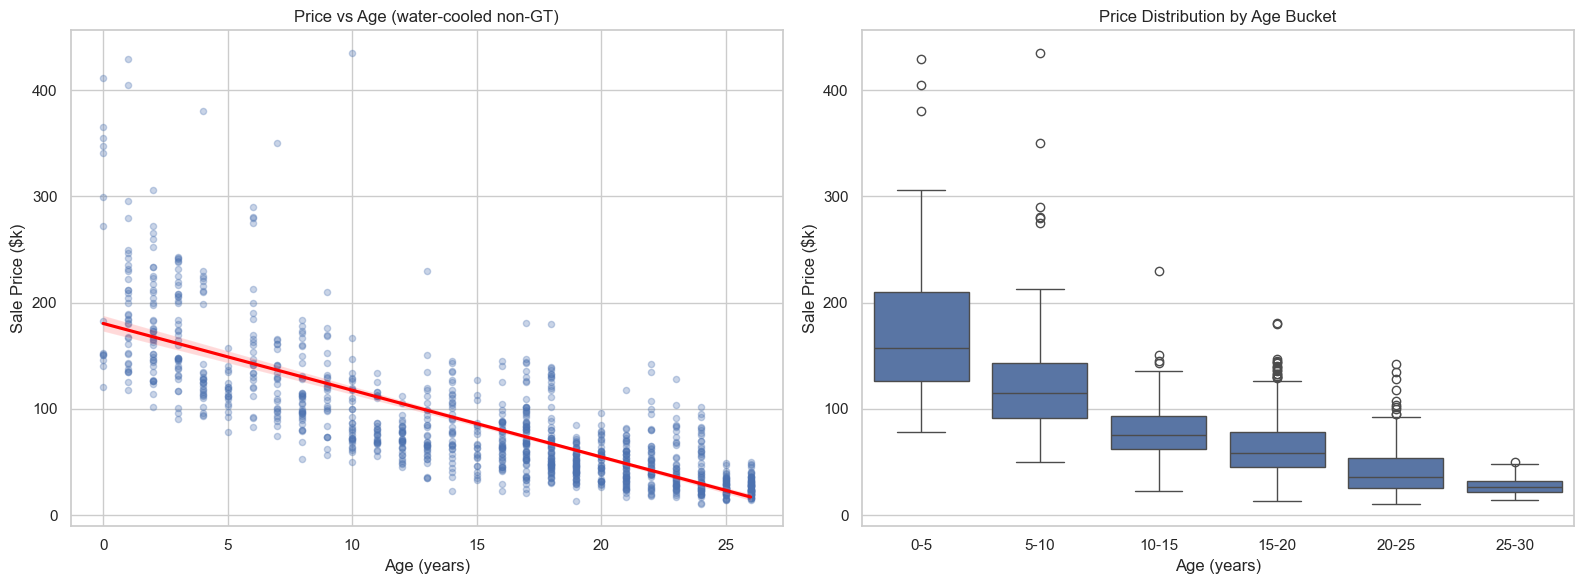

In [15]:
# Price by Age - scatter with trend and box plots (water-cooled non-GT)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter with regression line
ax = axes[0]
df_age = df_main[df_main["age"].notna()].copy()
sns.regplot(
    data=df_age,
    x="age",
    y=df_age["sale_price"] / 1000,
    scatter_kws={"alpha": 0.3, "s": 20},
    line_kws={"color": "red"},
    ax=ax,
)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Age (water-cooled non-GT)")

# Box plot by age buckets
ax = axes[1]
df_age["age_bucket"] = pd.cut(
    df_age["age"],
    bins=[0, 5, 10, 15, 20, 25, 30],
    labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30"],
)
order = ["0-5", "5-10", "10-15", "15-20", "20-25", "25-30"]
sns.boxplot(
    data=df_age,
    x="age_bucket",
    y=df_age["sale_price"] / 1000,
    order=order,
    ax=ax,
)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price Distribution by Age Bucket")

plt.tight_layout()
plt.show()

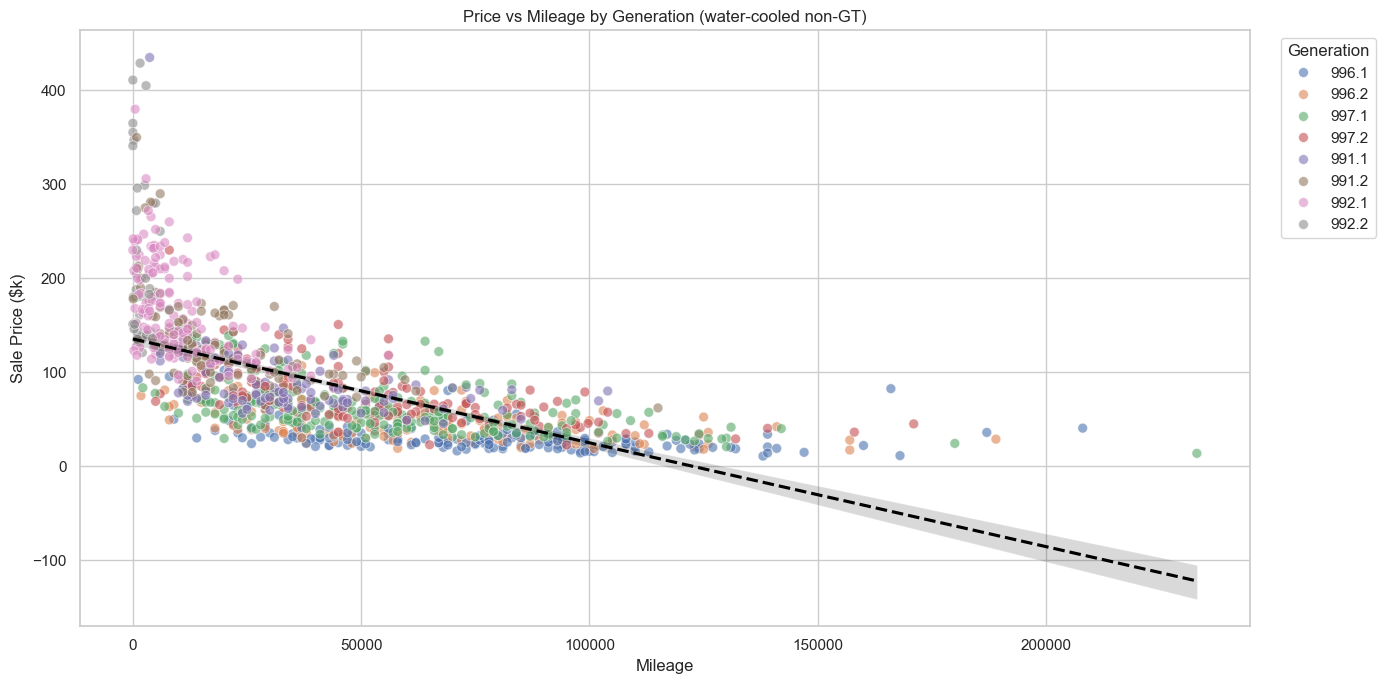

In [16]:
fig = plot_price_scatter(
    df_main,
    x_col="mileage",
    hue_col="generation",
    hue_order=WATER_COOLED_GENS,
    title="Price vs Mileage by Generation (water-cooled non-GT)",
)
plt.show()

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/eda_viz.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


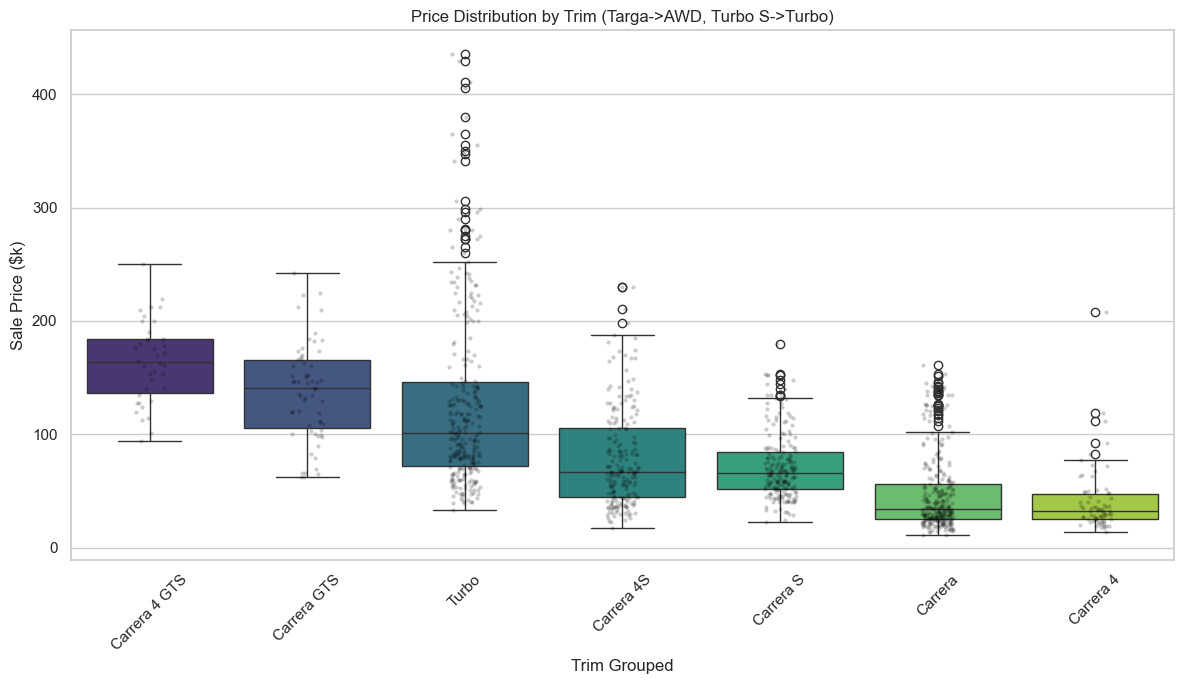

In [17]:
fig = plot_price_by_category(
    df_main,
    category_col="trim_grouped",
    title="Price Distribution by Trim (Targa->AWD, Turbo S->Turbo)",
)
plt.show()

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/eda_viz.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


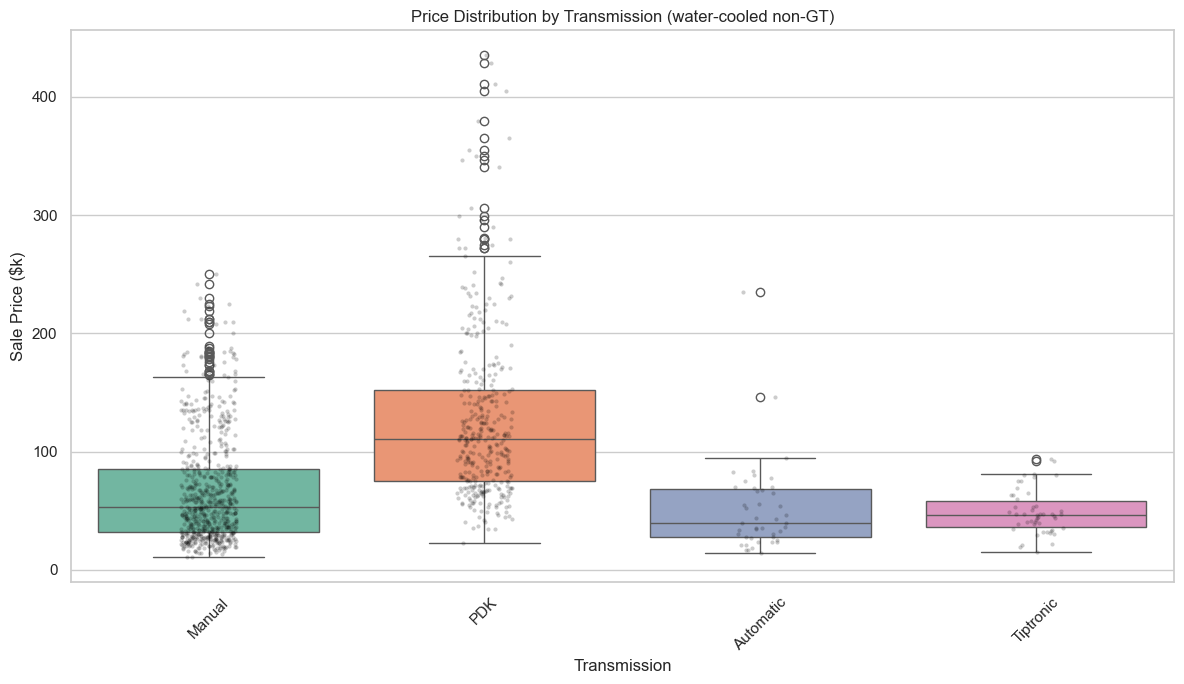

In [18]:
fig = plot_price_by_category(
    df_main,
    category_col="transmission",
    order=["Manual", "PDK", "Automatic", "Tiptronic"],
    palette="Set2",
    title="Price Distribution by Transmission (water-cooled non-GT)",
)
plt.show()

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/eda_viz.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


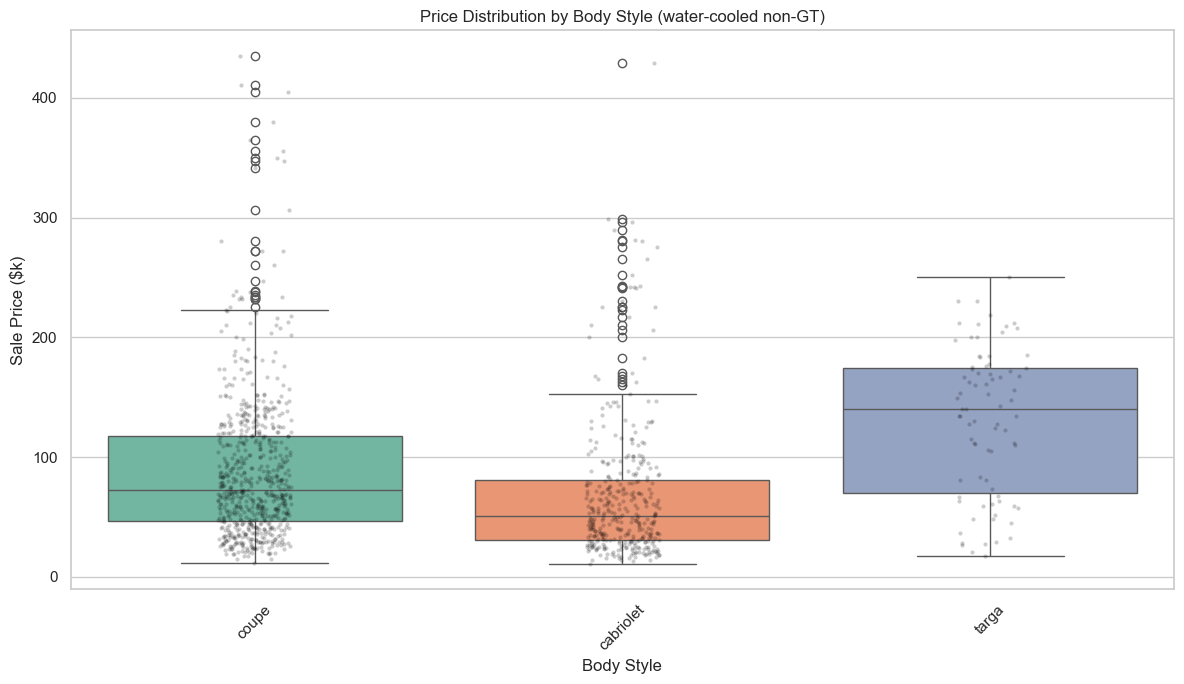

In [19]:
fig = plot_price_by_category(
    df_main,
    category_col="body_style",
    order=["coupe", "cabriolet", "targa", "speedster"],
    palette="Set2",
    title="Price Distribution by Body Style (water-cooled non-GT)",
)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/eda_viz.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list

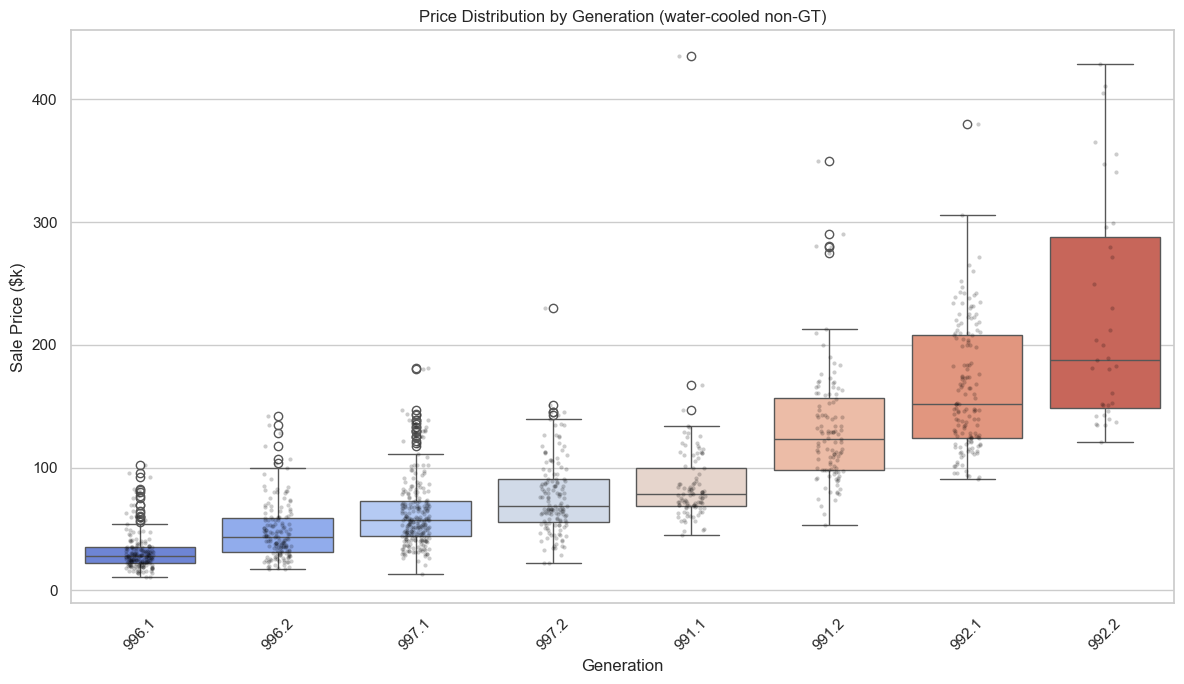

In [20]:
fig = plot_price_by_category(
    df_main,
    category_col="generation",
    order=WATER_COOLED_GENS,
    palette="coolwarm",
    title="Price Distribution by Generation (water-cooled non-GT)",
)
plt.show()

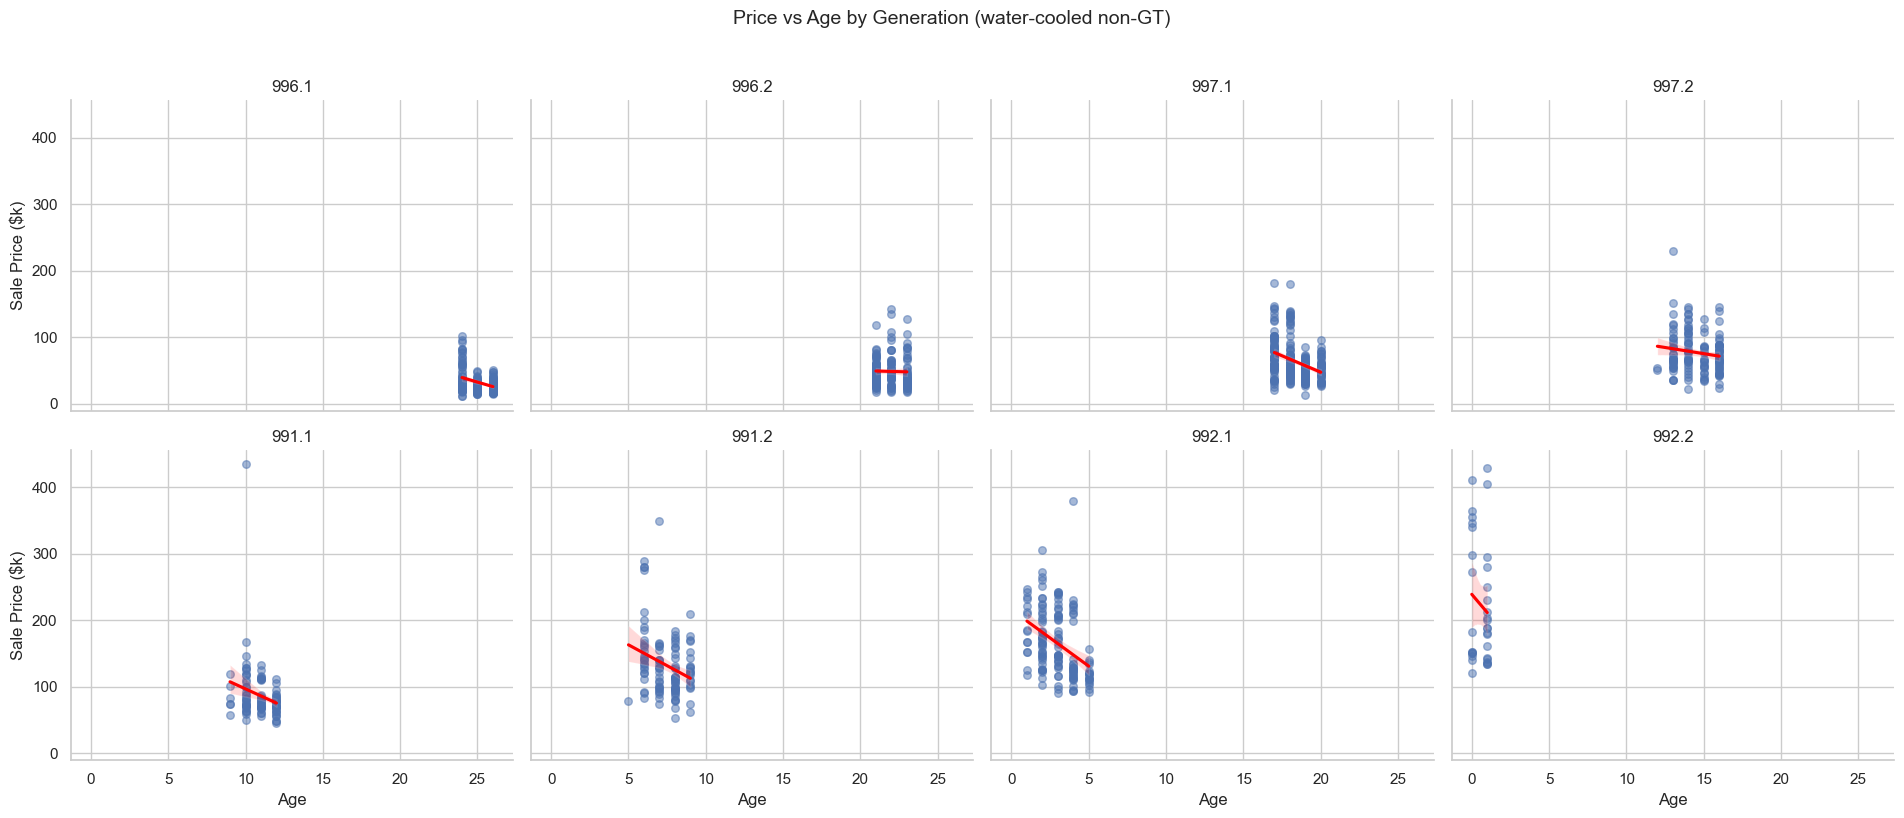

In [21]:
g = plot_faceted_scatter(
    df_main,
    x_col="age",
    facet_col="generation",
    col_order=WATER_COOLED_GENS,
    title="Price vs Age by Generation (water-cooled non-GT)",
)
plt.show()

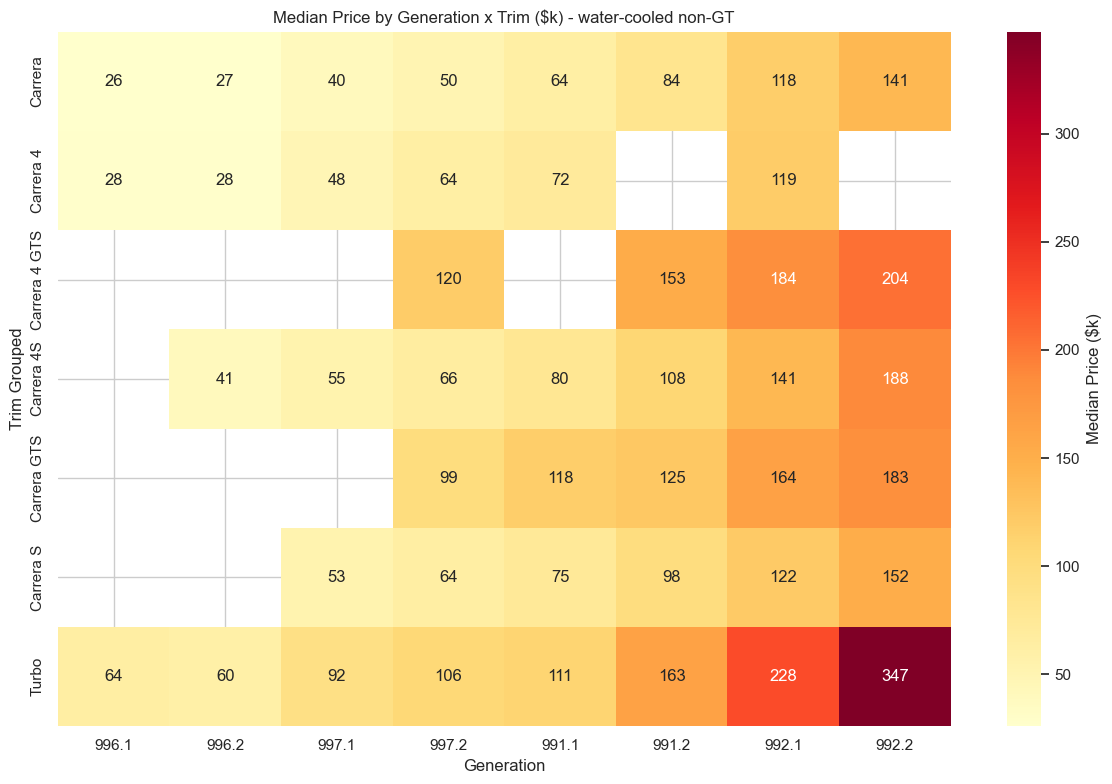

In [22]:
fig = plot_price_heatmap(
    df_main,
    row_col="trim_grouped",
    col_col="generation",
    col_order=WATER_COOLED_GENS,
    title="Median Price by Generation x Trim ($k) - water-cooled non-GT",
)
plt.show()

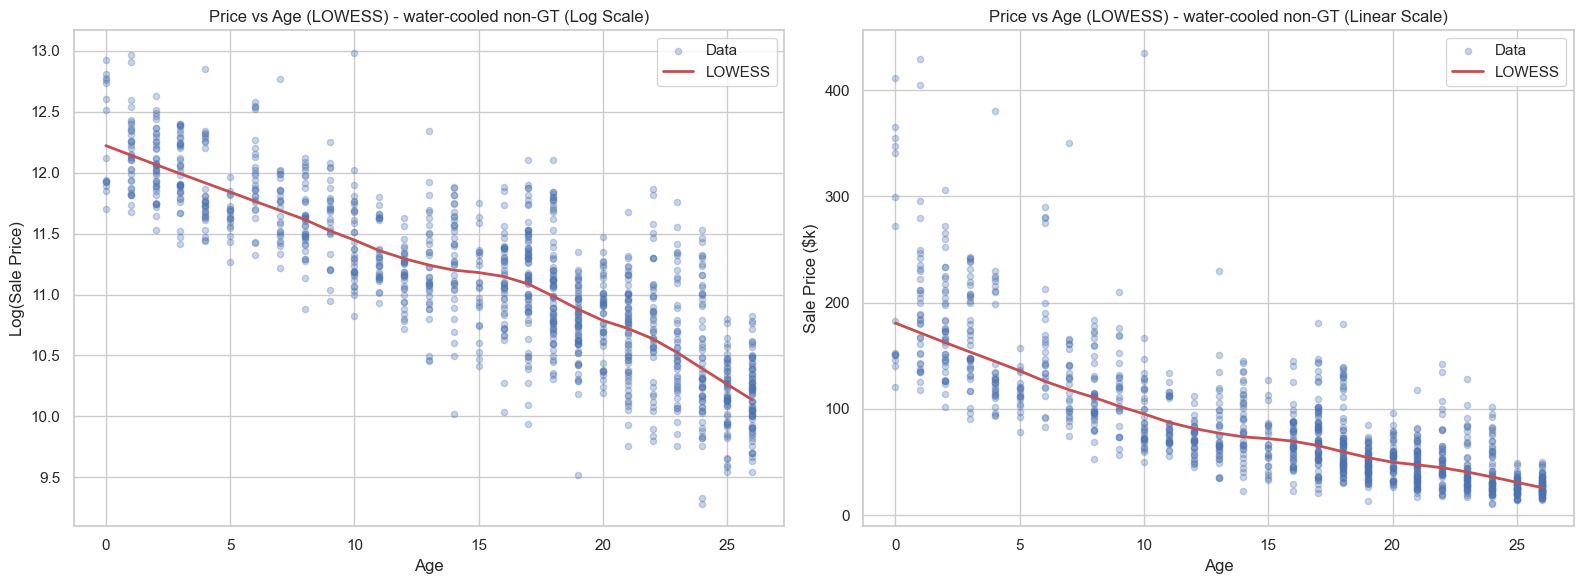

In [23]:
fig = plot_lowess_curves(df_main, x_col="age", title="Price vs Age (LOWESS) - water-cooled non-GT")
plt.show()

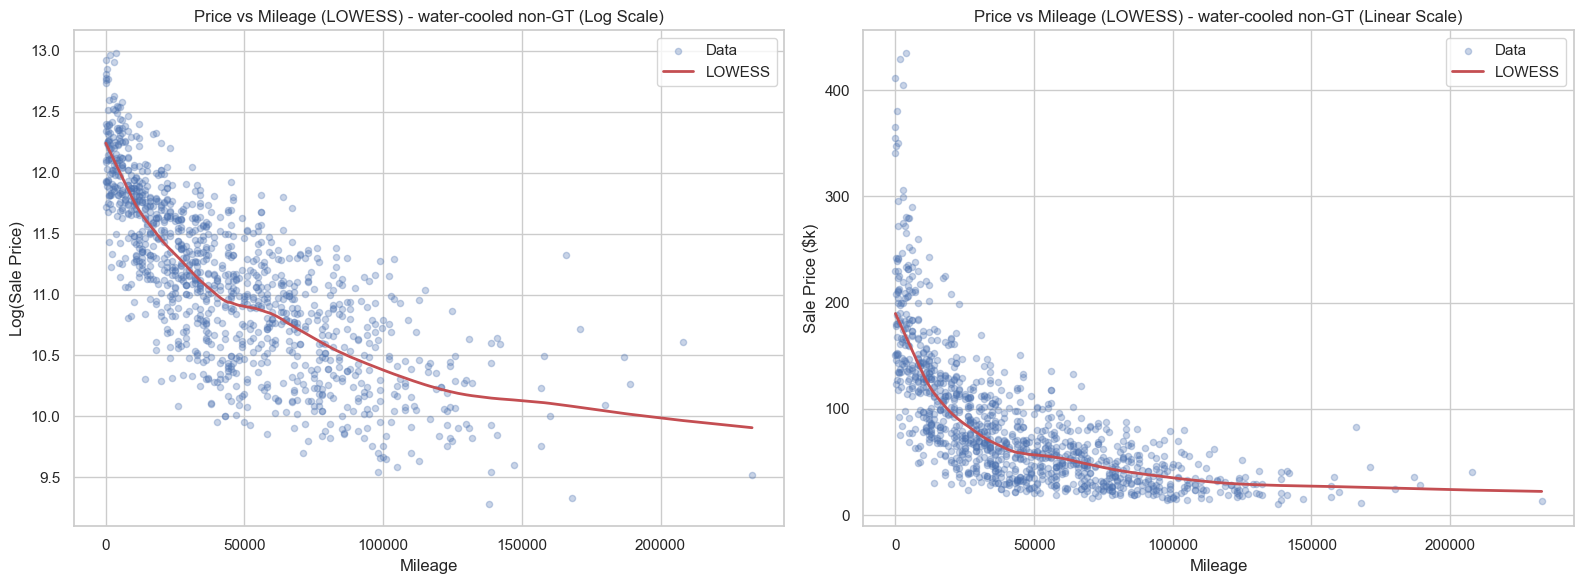

In [24]:
fig = plot_lowess_curves(
    df_main, x_col="mileage", title="Price vs Mileage (LOWESS) - water-cooled non-GT"
)
plt.show()

## GT Models (Separate Analysis)

GT3, GT3 RS, GT2 RS, GT3 Touring - track-focused variants with different pricing dynamics.

In [25]:
# GT models summary
if len(df_gt) > 0:
    print(f"GT Models: {len(df_gt)} listings")
    print(f"\nBy trim:")
    display(df_gt["trim"].value_counts().to_frame("count"))

    print(f"\nBy generation:")
    display(
        df_gt.groupby(["generation", "trim"])["sale_price"].agg(["count", "median"]).sort_index()
    )
else:
    print("No GT models in dataset")

GT Models: 251 listings

By trim:


,count
trim,
GT3,96
GT3 RS,74
GT3 Touring,65
GT2 RS,16



By generation:


count    median
generation trim                        
991.1      GT3             16  117000.0
991.2      GT2 RS          16  475500.0
           GT3             23  180000.0
           GT3 RS          25  221000.0
           GT3 Touring     13  255000.0
992.1      GT3             26  246000.0
           GT3 RS          10  405444.0
           GT3 Touring     47  280005.0
992.2      GT3              5  266000.0
           GT3 RS          26  403000.0
           GT3 Touring      5  273000.0
996.1      GT3              1   53000.0
996.2      GT3              5  107000.0
           GT3 RS           1  185000.0
997.1      GT3             14  119000.0
           GT3 RS           5  395997.0
997.2      GT3              6  165000.0
           GT3 RS           7  420000.0

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_16883/1631866043.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


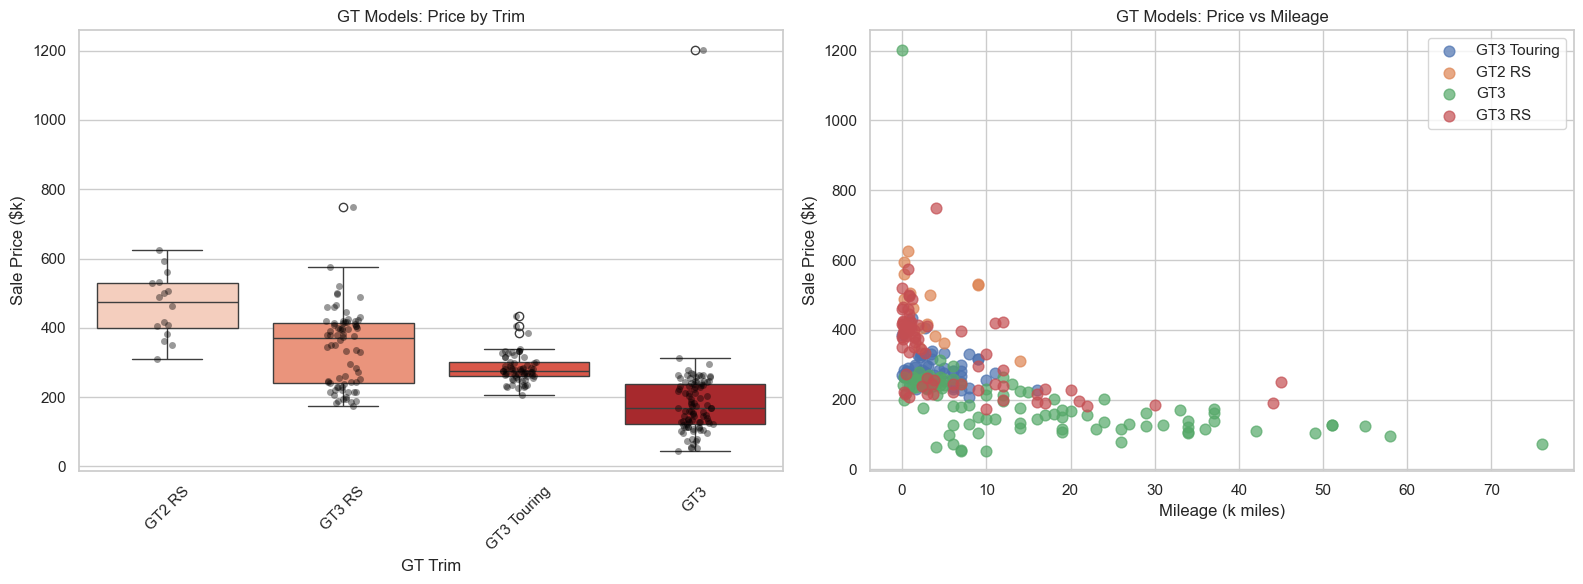

In [26]:
# GT models visualization
if len(df_gt) >= 5:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Price by trim
    ax = axes[0]
    trim_order = df_gt.groupby("trim")["sale_price"].median().sort_values(ascending=False).index
    sns.boxplot(
        data=df_gt,
        x="trim",
        y=df_gt["sale_price"] / 1000,
        order=trim_order,
        palette="Reds",
        ax=ax,
    )
    sns.stripplot(
        data=df_gt,
        x="trim",
        y=df_gt["sale_price"] / 1000,
        order=trim_order,
        color="black",
        alpha=0.4,
        size=5,
        ax=ax,
    )
    ax.set_xlabel("GT Trim")
    ax.set_ylabel("Sale Price ($k)")
    ax.set_title("GT Models: Price by Trim")
    ax.tick_params(axis="x", rotation=45)

    # Price vs mileage for GTs
    ax = axes[1]
    df_gt_plot = df_gt[df_gt["mileage"].notna()].copy()
    df_gt_plot["mileage_k"] = df_gt_plot["mileage"] / 1000
    df_gt_plot["price_k"] = df_gt_plot["sale_price"] / 1000

    for trim in df_gt_plot["trim"].unique():
        subset = df_gt_plot[df_gt_plot["trim"] == trim]
        ax.scatter(subset["mileage_k"], subset["price_k"], label=trim, alpha=0.7, s=60)

    ax.set_xlabel("Mileage (k miles)")
    ax.set_ylabel("Sale Price ($k)")
    ax.set_title("GT Models: Price vs Mileage")
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Not enough GT data for visualization")

## Prepare Model-Ready Data

In [27]:
df_model = prepare_model_data(df)
print(f"Model-ready data: {len(df_model)} listings")
display(df_model.head())

INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model-ready data: 1360 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,...,mileage_10k,mileage_scaled,log_mileage,log_mileage_scaled,is_low_mileage,color_normalized,color_category,body_style,log_price,is_valid
7,https://bringatrailer.com/listing/2020-porsche...,6k-Mile 2020 Porsche 911 Carrera 4S Coupe,137000,2025-12-24,2020,992.1,Carrera 4S,PDK,6000,Aventurine Green Metallic,...,0.6,-0.890287,8.699681,-0.63742,1,Aventurine Green Metallic,standard,coupe,11.827736,True
11,https://bringatrailer.com/listing/2024-porsche...,2024 Porsche 911 GT3 Touring 6-Speed,272000,2025-12-23,2024,992.2,GT3 Touring,Manual,3000,Chalk,...,0.3,-0.968545,8.006701,-1.039252,1,Chalk,special,coupe,12.513557,True
12,https://bringatrailer.com/listing/2018-porsche...,Signal Green 2018 Porsche 911 GT2 RS Weissach,531111,2025-12-24,2018,991.2,GT2 RS,PDK,9000,-to-Sample Signal Green,...,0.9,-0.81203,9.105091,-0.402338,1,-to-Sample Signal Green,PTS,coupe,13.182726,True
14,https://bringatrailer.com/listing/2022-porsche...,2022 Porsche 911 Carrera 4 GTS Cabriolet 7-Speed,165000,2025-12-25,2022,992.1,Carrera 4 GTS,Manual,13000,Jet Black Metallic,...,1.3,-0.707687,9.472782,-0.189129,0,Jet Black Metallic,standard,cabriolet,12.013701,True
17,https://bringatrailer.com/listing/2002-porsche...,2002 Porsche 911 Turbo Coupe 6-Speed,69000,2025-12-24,2002,996.2,Turbo,Manual,73000,Guards Red,...,7.3,0.857458,11.198228,0.811391,0,Guards Red,special,coupe,11.141862,True


In [28]:
# Save cleaned data
df.to_parquet(OUTPUT_PATH, index=False)
print(f"Saved cleaned data to {OUTPUT_PATH}")

Saved cleaned data to ../data/processed/cleaned_listings.parquet
